# Demonstrate adding day and night to a scada dataframe

This notebook shows how, given lat/long and UTC time, a column with a boolean is_day value is added
This can be useful for a quick partinioning of the data into these two bins

In [1]:

from pathlib import Path
import pandas as pd


from flasc.dataframe_operations.dataframe_manipulations import is_day_or_night, plot_sun_altitude_with_day_night_color


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from floris.tools import FlorisInterface

import flasc.model_tuning.floris_tuning as ft
from flasc.model_tuning.tuner_utils import set_fi_param, resim_floris
from flasc.energy_ratio.energy_ratio_input import EnergyRatioInput
from flasc.energy_ratio import energy_ratio as er

from flasc.utilities_examples import load_floris_smarteole

import flasc.floris_tools as ftools

In [3]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# Step 0: Demonstrate day/night selection

Load the processed SCADA data with power curve filtering and northing calibration applied and apply day/night identification in various ways

In [4]:
root_path = Path.cwd()
f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.ftr"
df_scada = pd.read_feather(f)

## Add is_day flag

Use the approximate lat/long of the wind farm to identify day/night using sun altitude

Text(0.5, 1.0, 'First 5000 points')

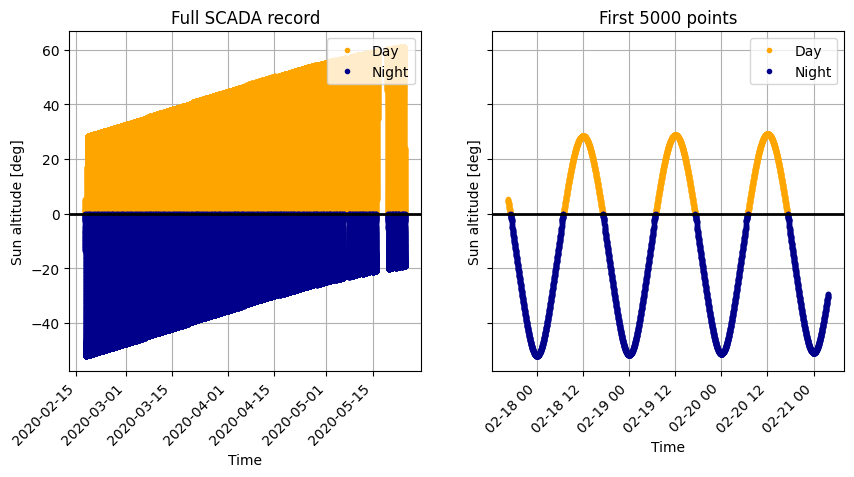

In [5]:
latitude = 49.8435
longitude = 2.801556

# Compute day/night in default settings and plot
df_scada = is_day_or_night(df_scada, latitude, longitude)

# Plot the day/night data
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)
plot_sun_altitude_with_day_night_color(df_scada, ax=ax[0])
plot_sun_altitude_with_day_night_color(df_scada.iloc[:5000], ax=ax[1])

ax[0].set_title("Full SCADA record")
ax[1].set_title("First 5000 points")

Text(0.5, 1.0, 'First 5000 points')

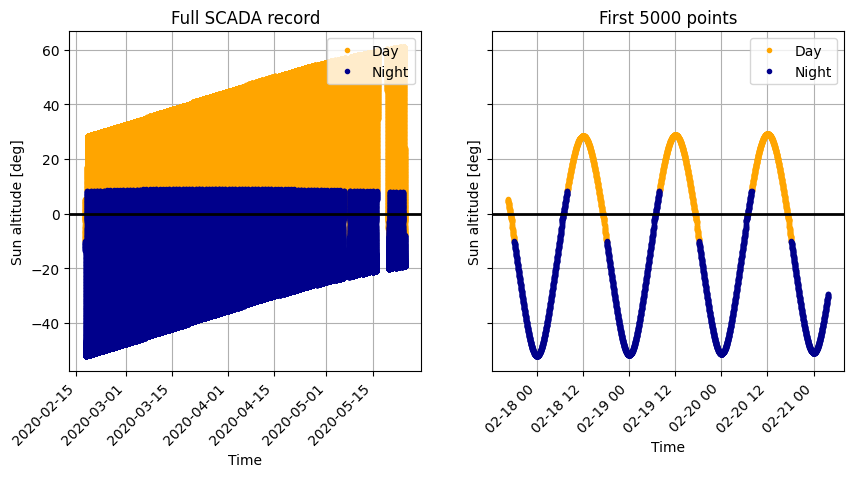

In [6]:
# Use lag feature
df_scada = is_day_or_night(df_scada, latitude, longitude, lag_hours=1)

# Plot the day/night data
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)
plot_sun_altitude_with_day_night_color(df_scada, ax=ax[0])
plot_sun_altitude_with_day_night_color(df_scada.iloc[:5000], ax=ax[1])

ax[0].set_title("Full SCADA record")
ax[1].set_title("First 5000 points")

Text(0.5, 1.0, 'First 5000 points')

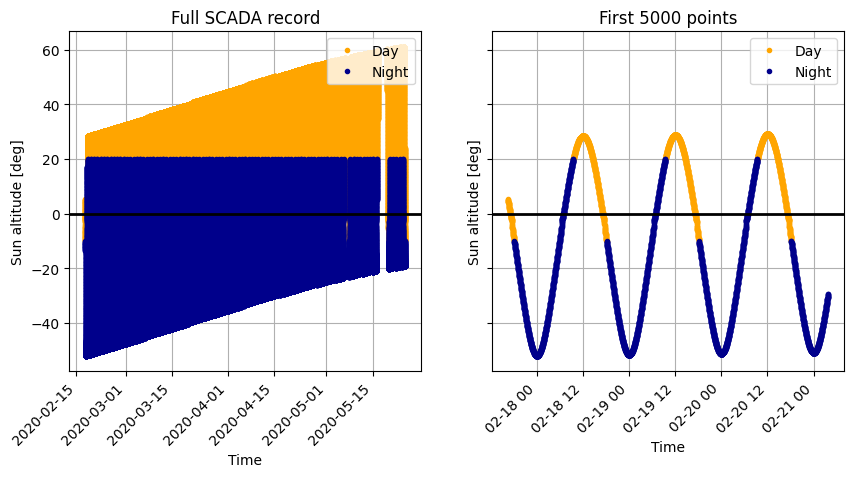

In [7]:
# Use sunrise, sunset altitude specification feature
df_scada = is_day_or_night(df_scada, latitude, longitude, sunrise_altitude=20, sunset_altitude=-10)

# Plot the day/night data
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 5)
plot_sun_altitude_with_day_night_color(df_scada, ax=ax[0])
plot_sun_altitude_with_day_night_color(df_scada.iloc[:5000], ax=ax[1])

ax[0].set_title("Full SCADA record")
ax[1].set_title("First 5000 points")

# Step 1: Add day-night flag to dataframe

In [8]:
# Compute one more time with defaults
df_scada = is_day_or_night(df_scada, latitude, longitude)

In [9]:
# Limit SCADA data to region of wake steering

# Specify offsets
start_of_offset = 200 # deg
end_of_offset = 240 # deg

# Limit SCADA to this region
df_scada = df_scada[(df_scada.wd_smarteole > (start_of_offset-20)) &
                    (df_scada.wd_smarteole < (end_of_offset+20))]

In [10]:
# Assign wd, ws and pow ref and subset SCADA based on reference variables used in the SMARTEOLE wake steering experiment (TODO reference the experiment)
df_scada = (df_scada
    .assign(
        wd = lambda df_: df_['wd_smarteole'],
        ws = lambda df_: df_['ws_smarteole'],
        pow_ref = lambda df_: df_['pow_ref_smarteole']
    )
)

In [11]:
# For tuning grab the reference, control and test turbines
ref_turbs = [0, 1, 2, 6]
test_turbs = [4]
control_turbs = [5]

In [12]:
# Split SCADA into baseline and wake steeering (controlled)
df_scada_baseline = df_scada[df_scada.control_mode=='baseline']
df_scada_controlled = df_scada[df_scada.control_mode=='controlled']

In [13]:
df_scada_baseline_day = df_scada_baseline[df_scada_baseline.is_day==True]
df_scada_baseline_night = df_scada_baseline[df_scada_baseline.is_day==False]
df_scada_controlled_day = df_scada_controlled[df_scada_controlled.is_day==True]
df_scada_controlled_night = df_scada_controlled[df_scada_controlled.is_day==False]

# Load the FLORIS model

In [14]:
fi, _ = load_floris_smarteole(wake_model="emgauss")
D = fi.floris.farm.rotor_diameters[0]

## Compare expansion tuning

In [15]:
wake_expansion_rates = np.arange(start=0.0005, stop=0.025, step=0.0005)

### Day Time

In [16]:
df_scada = df_scada_baseline_day.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    value_candidates=wake_expansion_rates,
    df_scada_in = df_scada,
    fi_in = fi,
    param_idx=0,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    wd_min=200, # FOCUS ON WAKE REGION WITH CONTROL
    wd_max=225 # FOCUS ON WAKE REGION WITH CONTROL
)
print(floris_wake_losses, scada_wake_loss)

[49.95161409 49.81462879 49.67765732 49.54079635 49.40416548 49.26777108
 49.13128743 48.9945279  48.85757018 48.72078058 48.58370562 48.44662645
 48.30971277 48.17258225 48.03523931 47.89790009 47.76026345 47.62240626
 47.48463302 47.34662882 47.20873575 47.0708069  46.93297876 46.795281
 46.65761937 46.52008085 46.38257971 46.24512063 46.10798976 45.9713699
 45.83509423 45.69921614 45.56386862 45.42879024 45.29385417 45.15911726
 45.0247815  44.89065423 44.75677344 44.62348383 44.49061373 44.35810488
 44.22587546 44.09391097 43.96227005 43.83100701 43.70016098 43.56976171
 43.43985456] 44.957492942499606


Text(0, 0.5, 'Percent Wake Loss')

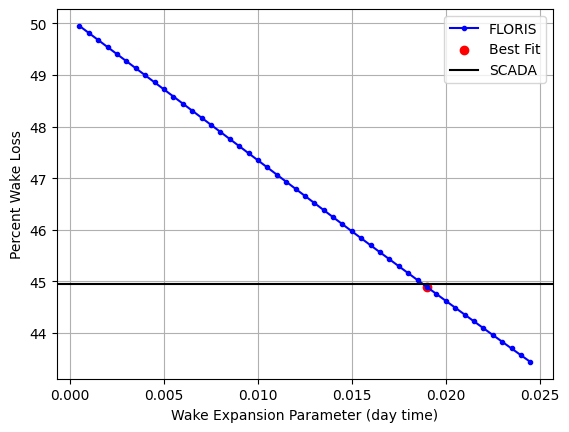

In [17]:
fig, ax = plt.subplots()
best_param_day = ft.select_best_wake_model_parameter(
    floris_wake_losses, 
    scada_wake_loss,
    wake_expansion_rates, 
    ax=ax
)
ax.set_xlabel('Wake Expansion Parameter (day time)')
ax.set_ylabel('Percent Wake Loss')

### Night Time


In [18]:
df_scada = df_scada_baseline_night.copy()
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    value_candidates=wake_expansion_rates,
    df_scada_in = df_scada,
    fi_in = fi,
    param_idx=0,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    wd_min=200, # FOCUS ON WAKE REGION WITH CONTROL
    wd_max=225 # FOCUS ON WAKE REGION WITH CONTROL
)
print(floris_wake_losses, scada_wake_loss)

[38.39640696 38.27545961 38.15484804 38.0343994  37.91413428 37.79411179
 37.67423966 37.55444961 37.4348068  37.31526599 37.19542619 37.07569498
 36.95602116 36.83614784 36.7163013  36.59658226 36.47692097 36.35721384
 36.23744907 36.11772196 35.99819231 35.87880321 35.75953617 35.64036197
 35.52137821 35.40233919 35.28357955 35.16485573 35.04645069 34.92824456
 34.81025154 34.69269265 34.57535392 34.45828786 34.34153203 34.22526718
 34.10941994 33.99396893 33.87892555 33.76429372 33.6501105  33.53628746
 33.42296999 33.3100638  33.197558   33.08548573 32.97376978 32.86239136
 32.75135086] 36.309972263002635


Text(0, 0.5, 'Percent Wake Loss')

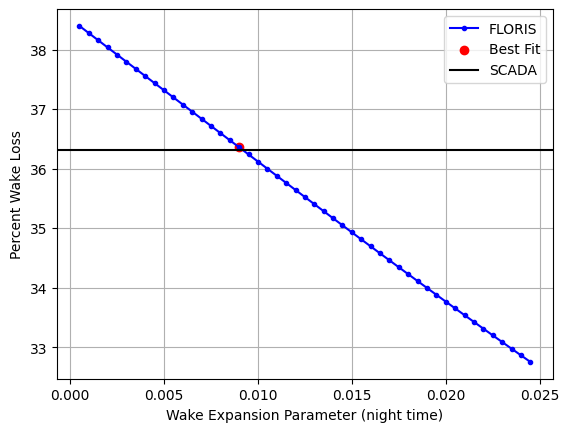

In [19]:
fig, ax = plt.subplots()
best_param_night = ft.select_best_wake_model_parameter(
    floris_wake_losses, 
    scada_wake_loss,
    wake_expansion_rates, 
    ax=ax
)
ax.set_xlabel('Wake Expansion Parameter (night time)')
ax.set_ylabel('Percent Wake Loss')

In [20]:
## Make models of FLORIS for daytime and night time

In [21]:
fi_day = set_fi_param(
    fi, 
    ['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    param_idx=0,
    value=best_param_day
)

fi_night = set_fi_param(
    fi, 
    ['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    param_idx=0,
    value=best_param_night
)

In [22]:
# Resimulate FLORIS
df_floris_day = resim_floris(fi_day, df_scada_baseline_day)
df_floris_night = resim_floris(fi_night, df_scada_baseline_night)

Text(0.5, 1.0, 'Comparing pre/post tuning FLORIS')

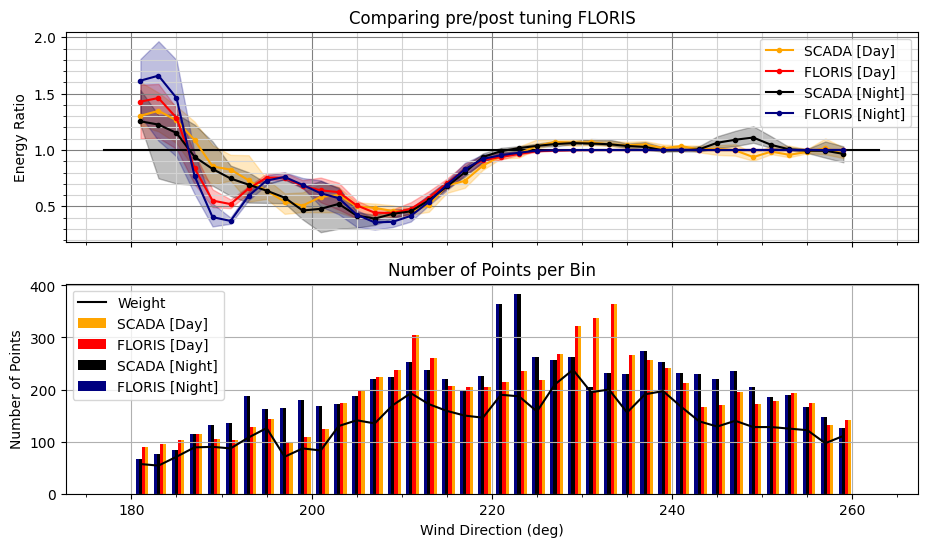

In [23]:
# Compare energy ratios

er_in = EnergyRatioInput(
    [df_scada_baseline_day, df_floris_day, df_scada_baseline_night,df_floris_night ],
    ["SCADA [Day]", "FLORIS [Day]", "SCADA [Night]", "FLORIS [Night]"]
)

er_out = er.compute_energy_ratio(
    er_in,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    ws_step=1.0,
    N=40
)
ax = er_out.plot_energy_ratios(overlay_frequency=True, 
                               color_dict={"SCADA [Day]":'orange',
                                           "FLORIS [Day]":'r',
                                           "SCADA [Night]":'k',
                                           "FLORIS [Night]":'navy',}
                               )
ax[0].set_title("Comparing pre/post tuning FLORIS")



# Horizontal deflection gains

In [24]:
hor_def_gains = np.arange(start=0.25, stop=4, step=0.25)

In [25]:
# Set the yaw angle matrix
yaw_vec_day = df_scada_controlled_day.wind_vane_005
yaw_vec_night = df_scada_controlled_night.wind_vane_005

yaw_angles_day = np.zeros((yaw_vec_day.shape[0],1,7))
yaw_angles_day[:,0,control_turbs[0]] = yaw_vec_day

yaw_angles_night = np.zeros((yaw_vec_night.shape[0],1,7))
yaw_angles_night[:,0,control_turbs[0]] = yaw_vec_night

### Daytime

In [26]:
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter = ['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_scada_baseline_day,
    df_scada_wakesteering_in=df_scada_controlled_day,
    fi_in=fi_day,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    yaw_angles_wakesteering=yaw_angles_day,
    ws_min=5,
    wd_min=205,
    wd_max=225
)

Text(0, 0.5, 'Percent Uplift')

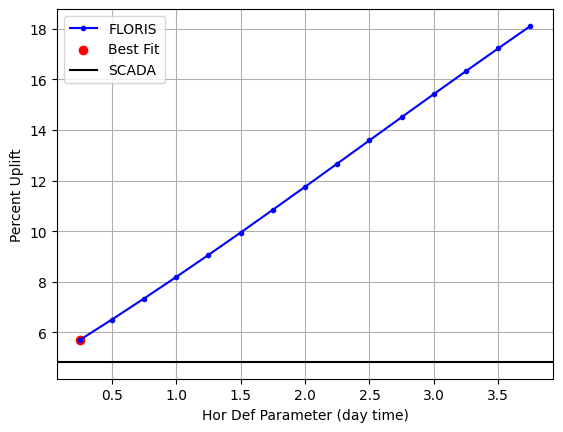

In [27]:

fig, ax = plt.subplots()
best_param_day = ft.select_best_wake_model_parameter(
    floris_uplifts, 
    scada_uplift,
    hor_def_gains, 
    ax=ax
)
ax.set_xlabel('Hor Def Parameter (day time)')
ax.set_ylabel('Percent Uplift')

NOTE: the plot above demonstrates a potential issue with how we are fitting the 
horizontal deflection parameter. Yawing reduces thrust so can produce a small uplift
even without any wake deflection actually occuring. We are looking into ways to 
improve the tuning of the horizontal deflection parameter.

### Night-time

In [28]:
floris_uplifts, scada_uplift = ft.sweep_deflection_parameter_for_total_uplift(
    parameter = ['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
    value_candidates=hor_def_gains,
    df_scada_baseline_in=df_scada_baseline_night,
    df_scada_wakesteering_in=df_scada_controlled_night,
    fi_in=fi_night,
    ref_turbines=ref_turbs,
    test_turbines=test_turbs,
    yaw_angles_wakesteering=yaw_angles_night,
    ws_min=5,
    wd_min=205,
    wd_max=225
)

Text(0, 0.5, 'Percent Uplift')

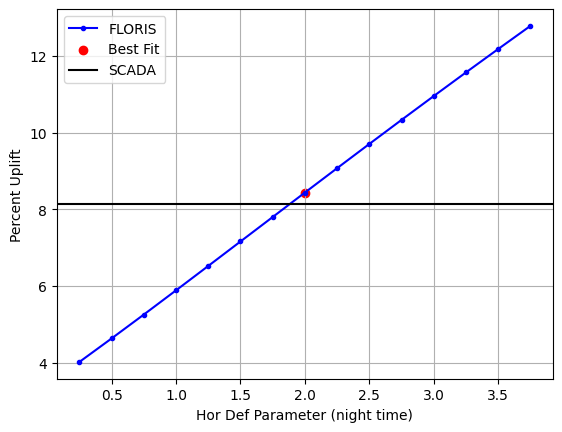

In [29]:
fig, ax = plt.subplots()
best_param = ft.select_best_wake_model_parameter(
    floris_uplifts, 
    scada_uplift,
    hor_def_gains, 
    ax=ax
)
ax.set_xlabel('Hor Def Parameter (night time)')
ax.set_ylabel('Percent Uplift')